
## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import Dataset
from sklearn.datasets import load_breast_cancer

## Load dataset and inspect features

Dataset shape: (569, 31)

Target distribution:
target
1    357
0    212
Name: count, dtype: int64


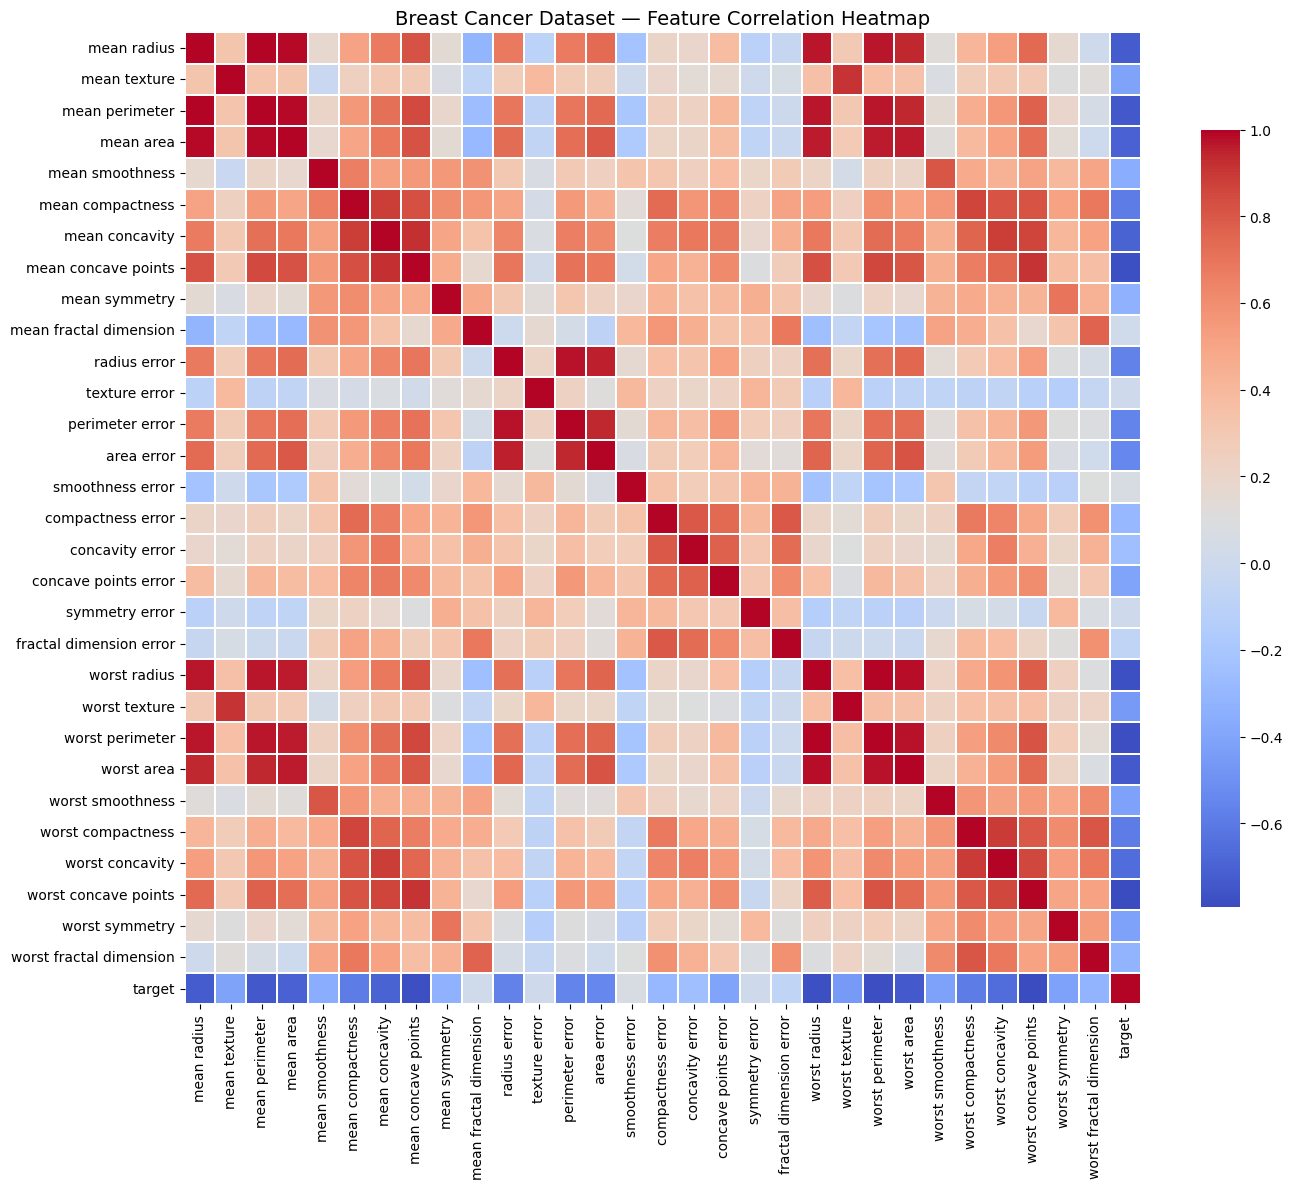


Top 10 features most correlated with the target:

worst concave points   -0.793566
worst perimeter        -0.782914
mean concave points    -0.776614
worst radius           -0.776454
mean perimeter         -0.742636
worst area             -0.733825
mean radius            -0.730029
mean area              -0.708984
mean concavity         -0.696360
worst concavity        -0.659610
Name: target, dtype: float64


In [ ]:
# Load dataset
data = load_breast_cancer()
X_all = data['data']
y_all = data['target']
feature_names = list(data['feature_names'])

# Create DataFrame
df = pd.DataFrame(X_all, columns=feature_names)
df['target'] = y_all

print("Dataset shape:", df.shape)
print("\nTarget distribution:")
print(df['target'].value_counts())

# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
)
plt.title("Breast Cancer Dataset — Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

# Show correlation of each feature with target (sorted)
target_corr = corr['target'].drop('target').sort_values(ascending=True)
print("\nTop 10 features most correlated with the target:\n")
print(target_corr.head(10))


## Choose top 2 features
  - worst concave points
  - worst perimeter

In [ ]:
# Select two features by name
feat1 = 'worst concave points'
feat2 = 'worst perimeter'

# find their column indices
i1 = feature_names.index(feat1)
i2 = feature_names.index(feat2)

# Select the two columns you chose
X = X_all[:, [i1, i2]].astype(np.float64)  # shape (N,2)
y = y_all.reshape(-1, 1).astype(np.float64) # shape (N,1)

print("Selected features:", feat1, "and", feat2)
print("X shape:", X.shape, "y shape:", y.shape)

# Standardize Features
def standardize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    std[std == 0] = 1.0
    return (train - mean) / std, (test - mean) / std, mean, std

# Shuffle and split 80/20
rng = np.random.default_rng(42)
indices = np.arange(X.shape[0])
rng.shuffle(indices)

train_size = int(0.8 * X.shape[0])
X_train_raw, X_test_raw = X[indices[:train_size]], X[indices[train_size:]]
y_train, y_test = y[indices[:train_size]], y[indices[train_size:]]

X_train, X_test, mean, std = standardize(X_train_raw, X_test_raw)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Selected features: worst concave points and worst perimeter
X shape: (569, 2) y shape: (569, 1)
Train shape: (455, 2) Test shape: (114, 2)


## Define a simple neural network (with ReLU)

In [ ]:
class SimpleNN:
    def __init__(self, n_input=2, n_hidden=4, lr=0.01, seed=1):
        rng = np.random.default_rng(seed)
        self.W1 = rng.normal(0, 0.1, (n_input, n_hidden))
        self.b1 = np.zeros((1, n_hidden))
        self.W2 = rng.normal(0, 0.1, (n_hidden, 1))
        self.b2 = np.zeros((1, 1))
        self.lr = lr

    def relu(self, z):
        return np.maximum(0, z)
    def relu_derivative(self, z):
        return (z > 0).astype(float)
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    def compute_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)  # MSE

    def backward(self, X, y):
        N = X.shape[0]
        dA2 = (self.A2 - y) * (2 / N)
        dZ2 = dA2 * self.sigmoid_derivative(self.A2)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict(self, X):
        return (self.forward(X) >= 0.5).astype(float)


## Train the network

Iter 100/1000 - Loss: 0.23750 | Train acc: 0.626 | Test acc: 0.632
Iter 200/1000 - Loss: 0.22846 | Train acc: 0.626 | Test acc: 0.632
Iter 300/1000 - Loss: 0.21034 | Train acc: 0.626 | Test acc: 0.632
Iter 400/1000 - Loss: 0.17883 | Train acc: 0.626 | Test acc: 0.632
Iter 500/1000 - Loss: 0.14613 | Train acc: 0.626 | Test acc: 0.632
Iter 600/1000 - Loss: 0.11970 | Train acc: 0.932 | Test acc: 0.939
Iter 700/1000 - Loss: 0.10001 | Train acc: 0.941 | Test acc: 0.956
Iter 800/1000 - Loss: 0.08588 | Train acc: 0.938 | Test acc: 0.947
Iter 900/1000 - Loss: 0.07582 | Train acc: 0.934 | Test acc: 0.947
Iter 1000/1000 - Loss: 0.06857 | Train acc: 0.941 | Test acc: 0.947


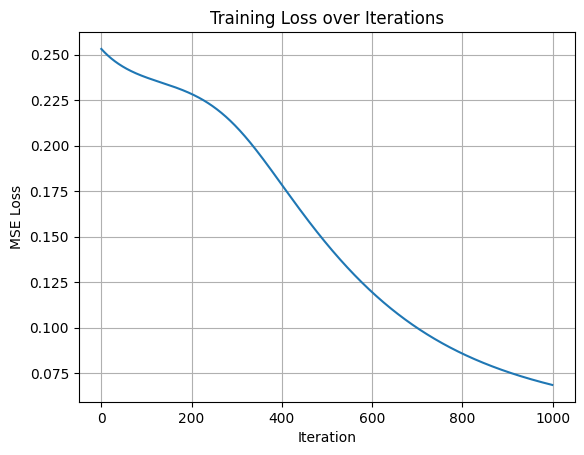

In [ ]:
model = SimpleNN(n_input=2, n_hidden=4, lr=0.05, seed=42)
n_iters = 1000
losses = []

for it in range(n_iters):
    y_pred = model.forward(X_train)
    loss = model.compute_loss(y_pred, y_train)
    losses.append(loss)
    model.backward(X_train, y_train)
    if (it + 1) % 100 == 0:
        train_acc = (model.predict(X_train) == y_train).mean()
        test_acc = (model.predict(X_test) == y_test).mean()
        print(f"Iter {it+1}/{n_iters} - Loss: {loss:.5f} | Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

plt.plot(losses)
plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


## Visualize Decision Boundary

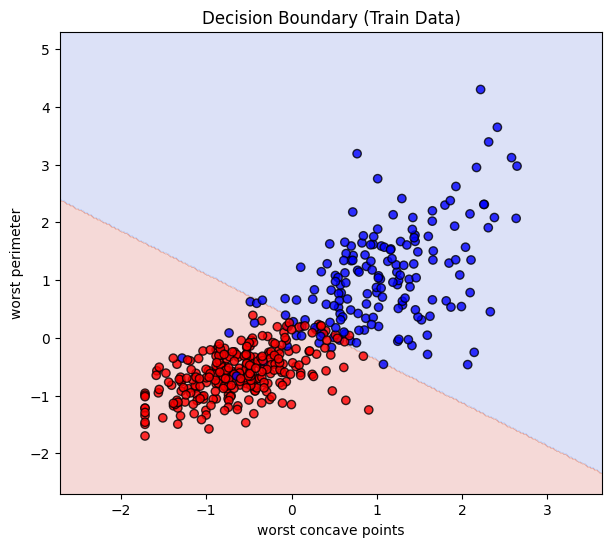

In [ ]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.2)
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap='bwr', edgecolor='k', alpha=0.8)
    plt.title(title)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.show()

plot_decision_boundary(model, X_train, y_train, "Decision Boundary (Train Data)")
